In [1]:
pwd

'/home/gil/gcubme_ai2/Workspace/JH_Lee/juhui_pancreas/head_op/isotropic_voxel_recon/05_DL_model/04_residual_dense/CV1'

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import tensorflow as tf
import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras import backend as K
#from keras.utils import multi_gpu_model
from tqdm import tqdm
from keras.layers import *
from keras.layers.normalization import BatchNormalization

/home/gil/anaconda3/envs/jjj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gil/anaconda3/envs/jjj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gil/anaconda3/envs/jjj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gil/anaconda3/envs/jjj/lib/python3.6/site-packages/tensorf

In [3]:
IMG_DEPTH = 128
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

In [4]:
def load_data3D(img_dir, msk_dir, IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

   
    img_list = sorted(glob.glob(img_dir +'/*.npy'))
    msk_list = sorted(glob.glob(msk_dir +'/*.npy'))
    
        
    X = np.ndarray((0, IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    for dcm_no in tqdm(img_list):
        dcm_npy = np.load(dcm_no)    # shape = (IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS) 
        dcm_npy = np.expand_dims(dcm_npy, axis=0)
        X = np.concatenate((X, dcm_npy), axis=0)
        
    
    Y = np.ndarray((0, IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, 2), dtype=np.float32)
    for nii_no in tqdm(msk_list):
        nii_npy = np.load(nii_no)   # shape = (IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, 2) 
        nii_npy = np.expand_dims(nii_npy, axis=0)
        Y = np.concatenate((Y, nii_npy), axis=0)

    
    return X, Y

In [5]:
train_img_path = './train_img'
train_msk_path = './train_msk'
train_img, train_msk = load_data3D(train_img_path, train_msk_path, IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
np.save('./train_img.npy', train_img)
np.save('./train_msk.npy', train_msk)
print(f'train_img.dtype: {train_img.dtype} | train_img.shape: {train_img.shape}')
print(f'train_msk.dtype: {train_msk.dtype} | train_msk.shape: {train_msk.shape}')


print('='*50)


valid_img_path = './valid_img'
valid_msk_path = './valid_msk'
valid_img, valid_msk = load_data3D(valid_img_path, valid_msk_path, IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
np.save('./valid_img.npy', valid_img)
np.save('./valid_msk.npy', valid_msk)
print(f'valid_img.dtype: {valid_img.dtype} | valid_img.shape: {valid_img.shape}')
print(f'valid_msk.dtype: {valid_msk.dtype} | valid_msk.shape: {valid_msk.shape}')


print('='*50)


test_img_path = './test_img'
test_msk_path = './test_msk'
test_img, test_msk = load_data3D(test_img_path, test_msk_path, IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
np.save('./test_img.npy', test_img)
np.save('./test_msk.npy', test_msk)
print(f'test_img.dtype: {test_img.dtype} | test_img.shape: {test_img.shape}')
print(f'test_msk.dtype: {test_msk.dtype} | test_msk.shape: {test_msk.shape}')

100%|██████████| 630/630 [11:24<00:00,  1.09s/it]


train_img.dtype: float32 | train_img.shape: (630, 128, 128, 128, 1)
train_msk.dtype: float32 | train_msk.shape: (630, 128, 128, 128, 2)


100%|██████████| 209/209 [02:47<00:00,  1.25it/s]


valid_img.dtype: float32 | valid_img.shape: (209, 128, 128, 128, 1)
valid_msk.dtype: float32 | valid_msk.shape: (209, 128, 128, 128, 2)


100%|██████████| 209/209 [02:53<00:00,  1.20it/s]


test_img.dtype: float32 | test_img.shape: (209, 128, 128, 128, 1)
test_msk.dtype: float32 | test_msk.shape: (209, 128, 128, 128, 2)


In [6]:
train_img = np.load('./train_img.npy')
train_msk = np.load('./train_msk.npy')
valid_img = np.load('./valid_img.npy')
valid_msk = np.load('./valid_msk.npy')
test_img = np.load('./test_img.npy')
test_msk = np.load('./test_msk.npy')


train_img = train_img / 255.0
valid_img = valid_img / 255.0
test_img = test_img / 255.0


train_msk = train_msk[:,:,:,:,1]
valid_msk = valid_msk[:,:,:,:,1]
test_msk = test_msk[:,:,:,:,1]


train_msk = np.expand_dims(train_msk, axis=4)
valid_msk = np.expand_dims(valid_msk, axis=4)
test_msk = np.expand_dims(test_msk, axis=4)


print(train_img.shape, np.max(train_img), np.min(train_img), train_img.dtype)
print(train_msk.shape, np.max(train_msk), np.min(train_msk), train_msk.dtype)
print(valid_img.shape, np.max(valid_img), np.min(valid_img), valid_img.dtype)
print(valid_msk.shape, np.max(valid_msk), np.min(valid_msk), valid_msk.dtype)
print(test_img.shape, np.max(test_img), np.min(test_img), test_img.dtype)
print(test_msk.shape, np.max(test_msk), np.min(test_msk), test_msk.dtype)

(630, 128, 128, 128, 1) 1.0 0.0 float32
(630, 128, 128, 128, 1) 1.0 0.0 float32
(209, 128, 128, 128, 1) 1.0 0.0 float32
(209, 128, 128, 128, 1) 1.0 0.0 float32
(209, 128, 128, 128, 1) 1.0 0.0 float32
(209, 128, 128, 128, 1) 1.0 0.0 float32


no: 350


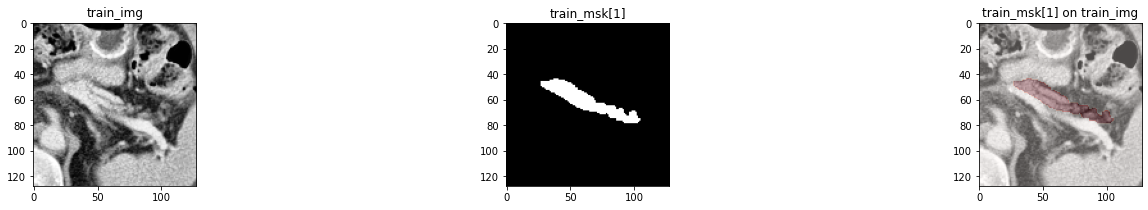

In [7]:
import random
no = random.randrange(0,train_img.shape[0])
print(f'no: {no}')

plt.figure(figsize=(24,3))


plt.subplot(1,3,1)
plt_sample_img = train_img[no, 64, :,:,:]
plt.title("train_img")
plt.imshow(plt_sample_img, cmap = 'gray')


plt.subplot(1,3,2)
plt_sample_msk = train_msk[no, 64, :,:,:]
plt.title("train_msk[1]")
plt.imshow(plt_sample_msk, cmap = 'gray')


plt.subplot(1,3,3)
plt_sample_img = train_img[no, 64, :,:,:]
plt_sample_msk = train_msk[no, 64, :,:,:]
plt.title("train_msk[1] on train_img")
plt.imshow(plt_sample_img, cmap = 'gray')
plt.imshow(plt_sample_msk, cmap = 'Reds', alpha = 0.3)

In [10]:
def upsample_conv(filters, kernel_size, strides, padding):
    return Conv3DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling3D(strides)

def DenseBlock(inputs, outdim):

    inputshape = K.int_shape(inputs)
    bn = BatchNormalization(axis=4, scale=False)(inputs)
    act = Activation('relu')(bn)
    conv1 = Conv3D(outdim, (3, 3, 3), activation=None, padding='same')(act)

    if inputshape[4] != outdim:
        shortcut = Conv3D(outdim, (1, 1, 1), padding='same')(inputs)
    else:
        shortcut = inputs
    result1 = add([conv1, shortcut])

    bn = BatchNormalization(axis=4, scale=False)(result1)
    act = Activation('relu')(bn)
    conv2 = Conv3D(outdim, (3, 3, 3), activation=None, padding='same')(act)
    result = add([result1, conv2, shortcut])
    result = BatchNormalization(axis=4, scale=False)(result)
    result = Activation('relu')(result)
    return result

def Dense_U_Net(input_img, mode = 'tran', base = 32, scale = 2, num_classes = 7):
    if mode == 'tran':
        upsample = upsample_conv
    elif mode == 'simp':
        upsample = upsample_simple
    conv1 = Conv3D(base, 3, activation=None, padding='same', kernel_initializer='he_normal')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation='relu')(conv1)
    conv1 = Conv3D(base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv1 = DenseBlock(conv1, 32)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D((scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation='relu')(conv2)
    conv2 = Conv3D((scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv2 = DenseBlock(conv2, 64)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D((scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation='relu')(conv3)
    conv3 = Conv3D((scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    conv3 = DenseBlock(conv3, 128)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D((scale * scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation='relu')(conv4)
    conv4 = Conv3D((scale * scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation='relu')(conv4)
    
    conv4 = DenseBlock(conv4, 256)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D((scale * scale * scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation(activation='relu')(conv5)
    conv5 = Conv3D((scale * scale * scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation(activation='relu')(conv5)
    
    conv5 = DenseBlock(conv5, 512)
    
    pool6 = upsample((scale * scale * scale) * base, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    merge = concatenate([conv4, pool6], axis = 4)
    conv6 = Conv3D((scale * scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(merge)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation(activation='relu')(conv6)
    conv6 = Conv3D((scale * scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation(activation='relu')(conv6)
    conv6 = DenseBlock(conv6, 256)

    pool7 = upsample((scale * scale) * base, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    merge = concatenate([conv3, pool7], axis = 4)
    conv7 = Conv3D((scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(merge)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation(activation='relu')(conv7)
    conv7 = Conv3D((scale * scale) * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation(activation='relu')(conv7)
    conv7 = DenseBlock(conv7, 128)

    pool8 = upsample(scale * base, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7)
    merge = concatenate([conv2, pool8], axis = 4)
    conv8 = Conv3D(scale * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(merge)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation(activation='relu')(conv8)
    conv8 = Conv3D(scale * base, 3, activation=None, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation(activation='relu')(conv8)
    conv8 = DenseBlock(conv8, 64)

    pool9 = upsample(base, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8)
    merge = concatenate([conv1, pool9], axis = 4)
    conv9 = Conv3D(base, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv9 = DenseBlock(conv9, 32)
    
    out = Conv3D(num_classes, 3, activation='sigmoid', padding='same')(conv9)
    model = Model(inputs=input_img, outputs=out)
    
    return model


In [11]:
input_img = Input(shape=(IMG_DEPTH, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model = Dense_U_Net(input_img, mode = 'simp', base = 32, scale = 2, num_classes = 1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 128 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 128 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [12]:
def dice_cost_0(y_true, y_predicted):

    mask_true = y_true[:, :, :, :, 0]
    mask_pred = y_predicted[:, :, :, :, 0]

    num_sum = 2.0 * K.sum(mask_true * mask_pred) + K.epsilon()
    den_sum = K.sum(mask_true) + K.sum(mask_pred)+ K.epsilon()

    return num_sum/den_sum



def dice_cost_1(y_true, y_predicted):

    mask_true = y_true[:, :, :, :, 1]
    mask_pred = y_predicted[:, :, :, :, 1]

    num_sum = 2.0 * K.sum(mask_true * mask_pred) + K.epsilon()
    den_sum = K.sum(mask_true) + K.sum(mask_pred)+ K.epsilon()

    return num_sum/den_sum


def dice_cost_1_loss(y_true, y_predicted):

    mask_true = y_true[:, :, :, :, 1]
    mask_pred = y_predicted[:, :, :, :, 1]

    num_sum = 2.0 * K.sum(mask_true * mask_pred) + K.epsilon()
    den_sum = K.sum(mask_true) + K.sum(mask_pred)+ K.epsilon()
    
    return 1-(num_sum/den_sum)


def dice_cost_01(y_true, y_predicted):

    dice_1 = dice_cost_0(y_true, y_predicted)
    dice_2 = dice_cost_1(y_true, y_predicted)


    return 1/2*(dice_1+dice_2)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [13]:
monitor = 'val_loss'

#model = multi_gpu_model(model, gpus=8)
model.compile(optimizer=Adam(lr=0.0001), loss=tversky_loss, metrics=[dice_cost_0])

checkpointer = ModelCheckpoint(filepath='./3D_residual_dense_Unet_CV1.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.1,
                              patience=10, min_lr=0.000001,verbose=1)
earlystopper = EarlyStopping(monitor=monitor, patience=35, verbose=1)

In [15]:
callbacks = [reduce_lr, earlystopper, checkpointer]

results = model.fit(train_img, train_msk, 
                    validation_data=(valid_img, valid_msk), 
                    epochs=500, 
                    verbose=1,
                    batch_size=2, 
                    callbacks=callbacks)


Train on 630 samples, validate on 209 samples
Epoch 1/500
630/630 [==============================] - 802s 1s/step - loss: 0.5303 - dice_cost_0: 0.4697 - val_loss: 0.3819 - val_dice_cost_0: 0.6169

Epoch 00001: val_loss improved from inf to 0.38189, saving model to ./3D_residual_dense_Unet_CV1.h5
Epoch 2/500
630/630 [==============================] - 747s 1s/step - loss: 0.2845 - dice_cost_0: 0.7155 - val_loss: 0.2904 - val_dice_cost_0: 0.7090

Epoch 00002: val_loss improved from 0.38189 to 0.29044, saving model to ./3D_residual_dense_Unet_CV1.h5
Epoch 3/500
630/630 [==============================] - 748s 1s/step - loss: 0.2564 - dice_cost_0: 0.7436 - val_loss: 0.2641 - val_dice_cost_0: 0.7356

Epoch 00003: val_loss improved from 0.29044 to 0.26415, saving model to ./3D_residual_dense_Unet_CV1.h5
Epoch 4/500
630/630 [==============================] - 748s 1s/step - loss: 0.2402 - dice_cost_0: 0.7598 - val_loss: 0.2730 - val_dice_cost_0: 0.7266

Epoch 00004: val_loss did not improve fro

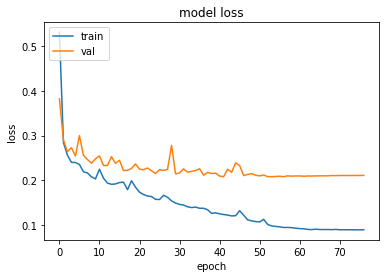

In [16]:
fig = plt.figure()
# plt.axes(facecolor='white')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
plt.savefig('loss.png')

In [17]:
from keras.models import load_model

#test_model = load_model('./3D_basic_Unet_CV1.h5',
#                   custom_objects = {'tversky_loss': tversky_loss,
#                                     'dice_cost_0': dice_cost_0,
#                                     'dice_cost_1': dice_cost_1,
#                                     'dice_cost_1_loss': dice_cost_1_loss})


test_model = load_model('./3D_residual_dense_Unet_CV1.h5',
                   custom_objects = {'tversky_loss': tversky_loss,
                                     'dice_cost_0': dice_cost_0})

test_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 128 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 128 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [18]:
test_img = np.load('./test_img.npy')
test_msk = np.load('./test_msk.npy')


test_img = test_img / 255.0

test_msk = test_msk[:,:,:,:,1]
test_msk = np.expand_dims(test_msk, axis=4)


print(test_img.shape, np.max(test_img), np.min(test_img), test_img.dtype)
print(test_msk.shape, np.max(test_msk), np.min(test_msk), test_msk.dtype)

(209, 128, 128, 128, 1) 1.0 0.0 float32
(209, 128, 128, 128, 1) 1.0 0.0 float32


In [19]:
test_pred = test_model.predict(test_img, batch_size=2, verbose=1)
#test_pred = model.predict(test_img, batch_size=2, verbose=1)

np.save('./pred_result_CV1.npy', test_pred)

print(test_pred.shape, np.max(test_pred), np.min(test_pred), test_pred.dtype)

209/209 [==============================] - 64s 308ms/step
(209, 128, 128, 128, 1) 1.0 0.0 float32


In [20]:
# 평가지표 구하는 수식
recall_list = []
specificity_list = []
precision_list = []
acc_list = []
dice_list = []

for i in range(test_msk.shape[0]):
    for j in range(test_msk.shape[1]):
        
        seg1 = test_pred[i,j,:,:,0] > 0.5
        gt1 = test_msk[i,j,:,:,0]
        
        #if np.sum(gt1) != 0:
            
        seg1_n = seg1 == 0
        seg1_t = seg1 == 1
        
        gt1_n = gt1 == 0
        gt1_t = gt1 == 1
        
        tp = np.sum(seg1_t&gt1_t)
        
        fp = np.sum(seg1_t&gt1_n)
        
        tn = np.sum(seg1_n&gt1_n)
        
        fn = np.sum(seg1_n&gt1_t)
        
       
        recall = tp / (tp + fn)
        if np.isnan(recall):
            #print('recall is nan {0}\t(tp:{1})\t tn:{2}\t fp:{3}\t(fn:{4})'.format(i, tp, tn, fp, fn))
            continue
        
        specificity = tn / (tn + fp)
        if np.isnan(specificity):
            #print('specificity is nan {0}\t tp:{1}\t(tn:{2})\t(fp:{3})\t fn:{4}'.format(i, tp, tn, fp, fn))
            continue
        
        precision = tp / (tp + fp)
        if np.isnan(precision):
            #print('precision is nan {0}\t(tp:{1})\t tn:{2}\t(fp:{3})\t fn:{4}'.format(i, tp, tn, fp, fn))
            continue
        
        acc = (tp + tn) / (tp + tn + fp + fn)
        if np.isnan(acc):
            #print('acc is nan {0}\t(tp:{1})\t(tn:{2})\t(fp:{3})\t(fn:{4})'.format(i, tp, tn, fp, fn))
            continue
            
        dice = (2 * tp) / ((2 * tp) + fp + fn)
        if np.isnan(dice):
            #print('dice is nan {0}\t(tp:{1})\t tn:{2}\t(fp:{3})\t(fn:{4})'.format(i, tp, tn, fp, fn))
            continue
        
        #print('='*50)
        recall_list.append(recall)
        specificity_list.append(specificity)
        precision_list.append(precision)
        acc_list.append(acc)
        dice_list.append(dice)

/home/gil/anaconda3/envs/jjj/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/gil/anaconda3/envs/jjj/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


In [21]:
from tabulate import tabulate
row_data1 = []
row_item1 = []

    
row_item1.append('{0:.4f}'.format(np.mean(recall_list)))
row_item1.append('{0:.4f}'.format(np.mean(specificity_list)))
row_item1.append('{0:.4f}'.format(np.mean(precision_list)))
row_item1.append('{0:.4f}'.format(np.mean(acc_list)))
row_item1.append('{0:.4f}'.format(np.mean(dice_list)))
row_data1.append(row_item1)

head1 = ["Sensitivity", "Specificity", "Precision", "Accuracy", "DSC"]
  
# display table
print(tabulate(row_data1, headers=head1, tablefmt="grid"))
#print(row_data1[n])
print('')

+---------------+---------------+-------------+------------+--------+
|   Sensitivity |   Specificity |   Precision |   Accuracy |    DSC |
+===============+===============+=============+============+========+
|        0.7921 |        0.9899 |      0.7893 |     0.9811 | 0.7626 |
+---------------+---------------+-------------+------------+--------+



In [ ]:
for i in range(0, test_img.shape[0]):
    
    os.makedirs('./result_img/' + str(format(i, '03')), exist_ok=True)
    for j in range(0, test_img.shape[1]):
        
        
        fig, axs = plt.subplots(1,3,constrained_layout=True)
        
        #plt.figure(figsize=(10, 20))
    
        axs[0].imshow(test_img[i,j,:,:,0], cmap='gray')
        axs[0].axis('off')
        

        axs[1].imshow(test_msk[i,j,:,:,0], cmap='gray')
        axs[1].axis('off')
    

        axs[2].imshow(test_img[i,j,:,:,0], cmap='gray')
        axs[2].imshow(test_pred[i,j,:,:,0] > 0.3, cmap='Reds', alpha=0.7)
        axs[2].axis('off')
    
        #plt.show()
        fig.savefig('./result_img/' + str(format(i, '03')) + '/'+ str(format(j, '03')) + '.png')